# Body position recognition using FastAI
> Recognising body parts during golf swing, step 1

- toc: true 
- badges: true
- categories: [jupyter]
- image: images/chart-preview.png

![](ghtop_images/header2.png)

## Introduction 

This is a first step in a project to analyse golf swings.

In this first step I try to identify different parts of the body and golf equipment during the golf swing. This step is of limited success for overall analysis but the steps used are useful for the lessons learnt.

This work uses deep learning to identify locations (vectors) on images and fitting by regression.



In this step I will use a dataSet found at <a href='https://github.com/wmcnally/golfdb'> Git Hub GolfSwing</a> and the paper of the work https://arxiv.org/abs/1903.06528.

What this dataset/paper does is split the golf swing into a number of sequences based on the position of the body and golf club, e.g. start, golf club parallel to ground, striking the ball etc. We will call these the golf positions. These positions are shown below.

<iframe src="https://giphy.com/embed/YiSd21YzHLbtbXxShr" width="480" height="270" frameBorder="0" class="giphy-embed" allowFullScreen></iframe><p><a href="https://giphy.com/gifs/YiSd21YzHLbtbXxShr">via GIPHY</a></p>

![](ghtop_images/Fig_GolfSwing.png)


The dataset includes a series of videos that have been characterised based on the different swing sequences. 


### Steps in this page

1. Download the video dataset and the details of the frames of the different positions

1. Create images at the different positions from the videos  

1. Classify points on the images and a file for each image of these

1. Upload data to GitHub and download on notebook for analysis

1. Use deep learning to identify the positions on the images


    

## Use the video analysis dataset to create images of golf swings

First I cloned the directory (https://github.com/wmcnally/golfdb) onto my local PC. I then need to identify which videos to use- I want the ones behind the golfer and preferably of lower frame rate.

Below are the names of the videos I selected

In [1]:
import numpy as np
import os

useVids=[1,3,5,7,13,24,43,46,48,71,77,81,83,89,93,242,681,1060]
np.shape(useVids)

(18,)

I now want to find the frames in each video that represent the selected positions.

These exist in a '.pkl' file. So we open the file and then select the videos (rows) we want to use.

In [16]:
import pandas as pd
import pickle

file_path= cda + "\data\\golfDB.pkl"

In [1]:
data = pickle.load(open(file_path,"rb"))
aa=[]
i=0
for ii in useVids:
    if i==0:
        aa=data[ii==data.id]
        
    else:
        aa=aa.append(data[ii==data.id])
       
    i=i+1
aa.reset_index(drop=True,inplace=True)
aa.tail()

![](ghtop_images/GOLF1.png)

In the DataFrame (aa) the details we want are just the 'events' so we know what frames to save as images from the videos

First we create a function that takes a video location and details of the frames (or the selected golf positions) and then creates a new folder containing images of those frames.

This uses the library `cv2` and a secondary check to normalise the positions if it is different from that given (this was useful in earlier versions but later ones the frame number matched that given by the aa dataFrame). 

The function works by finding a frame rate then stepping through the video by adding the time per frame after each step. If the frame is at a position given by the input (from aa) it is saved as an image.

In [17]:
def createImages(fila,pos):
    ''' 
    Given a video file location (fila) it will save as images to a folder
    Given positions in video (pos) these images from the video are saved
    pos is created based on positions of swings
    '''
    import cv2
    import numpy as np
    import os
    
    # create a video capture object
    cap = cv2.VideoCapture(fila)
    
    # get details of the video clip
    duration = cap.get(cv2.CAP_PROP_POS_MSEC)
    
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = cap.get(cv2.CAP_PROP_FPS)
    duration_seconds = frame_count / fps
    print('duration is ',duration,'. frame_count is ',frame_count,'. fps is ',fps,'. duration sec is',duration_seconds)
    
    #alter pos based on frame count
    posb4=pos
    pos=(pos/(np.max(pos)/frame_count))
    pos=np.array([int(nn) for nn in pos])
    pos=pos[1:-2]#ignore first value and last two
    
    
    # create a folder if it doesn't exist
    folder = fila.split('\\')[-1].split('.')[0]
    folder = '_images'+folder
    print(folder)
    try:
        os.mkdir(folder)
    except:
        pass

    
    vidcap = cap
    
    # this function creates an image from part of a video and 
    # saves as a JPG file
    def getFrame(sec,go):
        vidcap.set(cv2.CAP_PROP_POS_MSEC,sec)
        hasFrames,image = vidcap.read()
        if hasFrames and go:
            cv2.imwrite(os.path.join(folder,"frame{:d}.jpg".format(count)), image)     # save frame as JPG file
        return hasFrames
    
    # goes through the video clip and steps through based on frame rate
    sec = 0
    frameRate = 1000/fps 
    count=1
    go=0
    success = True
    while success:
        count = count + 1
        sec = sec + frameRate
        #only saves images if at positions in pos
        if count in pos:
            go=1
        else:
            go=0
        success = getFrame(sec,go)

    print("{} images are extacted in {}.".format(count,folder))

And below I call the script for the videos I selected

In [ ]:
import cv2
fila = cda + '\\data\\videos_160\\'
for ii,aai in enumerate(aa.id):
    fold = fila + str(aai)+'.mp4'
    pos=aa.iloc[ii,7]
    pos=pos-pos[0]
    if ii>1:
        cII(fold,pos)
        cap = createImages.VideoCapture(fold)


So now we have a series of folders for each video with images given by the selected positions

## Manually classify points on the images

To be able to perform analysis on the images they first need to be labelled.

To do this I decided to take the **manual** approach and classify the images myself. I decided to choose the following regions in each image:
- The ball
- The end of the golf club (clubhead)
- The back wrist
- the back elbow
- the top of the head


This is done using the follwing function

In [ ]:
def imDo(im):
    
    fig=plt.figure(figsize=(20, 15))
    plt.imshow(im)

    def tellme(s):
        print(s)
        plt.title(s, fontsize=16)

    tellme('You will define golf swing, click to begin')

    plt.waitforbuttonpress()

    while True:
        pts = []
        while len(pts) < 5:
            tellme('Select golf ball-golf club- wrist- elbow- head with mouse')
            pts = np.asarray(plt.ginput(5, timeout=-1))
            if len(pts) < 5:
                tellme('Too few points, starting over')
                time.sleep(1)  # Wait a second
        
        ph = plt.plot(pts[:, 0], pts[:, 1], marker='x',markersize=20,markeredgewidth=3)

        tellme('Happy? Key click for yes, mouse click for no')

        if plt.waitforbuttonpress():
            break
    plt.close(fig)
    return pts

Before we can call this function we want to make sure the image appears as a new window

Also some imports

In [ ]:
import fastbook

from fastbook import *
from fastai.vision.all import *
import matplotlib

cda = os.getcwd()

matplotlib.use('TKAgg')

Now for each image file created, the script below runs `imDo` which plots the image then asks the user to select 5 points on the image for classification.

these points are then save as txt file with the same name as the image file to be used later in modeling

![](ghtop_images/golfpos.png)

In [ ]:
foldOuta=cda+'//_dataSel//'
lsa = os.listdir(foldOuta)
lsa
ptsALL=[]
for ii,folds in enumerate(lsa):
    if ii>0:
        print(folds)
        img_files = get_image_files(foldOuta+folds)
        for fils in img_files:
            im = PILImage.create(fils)
            pts=imDo(im)
            ptsALL.append(pts)
            fnom=str(fils).split('\\')[-1].split('.')[0]
            
            np.savetxt(foldOuta+folds+'\\'+fnom+'.txt',pts)

## Upload data for use in modeling

Fastai has a function called `untar_data` that prepares images in a .tgz folder ready to use for analysis.

A tgz file can be made by a Python script, but all the ones I tried produced an error, so instead I used 

To create a tar file see https://opensource.com/article/17/7/how-unzip-targz-file

Open up a terminal go to the folder that contains the folder wanting to compress and then tar with the command line

<code>tar --create --verbose --file GC.tgz GolfComb</code>

I have then uploaded it to GitHub. Go to the file on Github open it and right click on 'view raw' and select copy link.

![](ghtop_images/Tar_Link.png)

## Model the data

The rest needs to be done with a GPU. I have done this with https://colab.research.google.com/ (free time is limited but details not published) and the code tab for a notebook on https://www.kaggle.com/ (36 h per month for free)

First import the fastai stuff

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [10]:
from fastai.vision.all import *

import os
import re
import numpy


untar the data and set the path

In [9]:
url='https://github.com/ThomasHSimm/GolfSwingTSimm/blob/main/_dataSel/GC.tgz?raw=true'

path = untar_data(url)

In [4]:
Path.BASE_PATH = path

Have a look at the data

In [11]:
(path/'Test').ls()

![](ghtop_images/GOLF6.png)

A function to classify the points on the image

Loads the text file for each image and returns a TensorPoint object of points on the image

In [75]:
def get_pointa_img(fileo):
     
    txtfile = str(fileo)[0:-4] + '.txt'
    # print(txtfile)
    pts=np.loadtxt(txtfile)
    pp=pts[-1,:]
    # print(pp)
    return TensorPoint(pp)

Create a DataBlock

The DataBlock is the foundation of the model. It needs to know
- the location of the images, 
- the label for the images (points on images in this case)
- separation of data into test and validation sets (done automatically if not specified)
- the type of data used `blocks=(ImageBlock, PointBlock)`
- any resizing of images
- any transforms (Data Augmentation)

In [117]:
item_tfms = [Resize(448, method='squish')]
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    item_tfms=item_tfms,
    get_y=get_pointa_img,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])

Now create a DataLoaders object which has the path of the data and the batch size (here 30)

Batch size is important to specify to avoid memory issues

In [119]:
dls = biwi.dataloaders(path,30)

Now create the learner

Pass it the dataLoaders, we're doing transfer learning from resnet50 (imageNet trained model), what metrics we'll use for loss, and the range in y values we want

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.02),y_range=(-1,1))

Have a look at the data. Can see the transforms

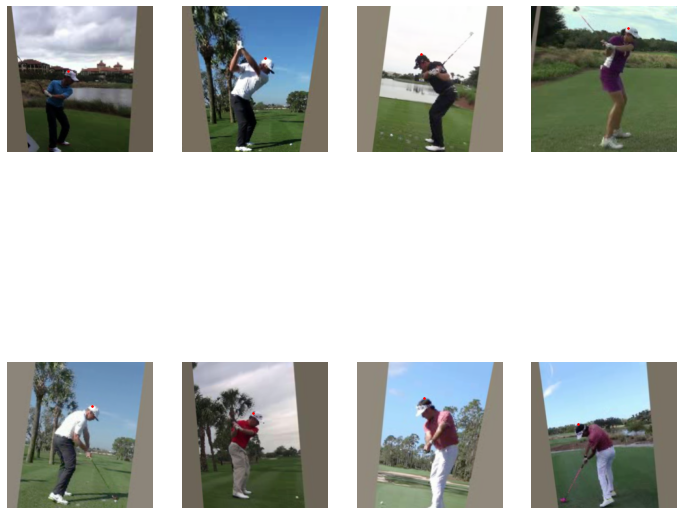

In [120]:
dls.show_batch(max_n=8, figsize=(12,12))

Find the best learning rate

In [8]:

learn.lr_find()

![](ghtop_images/GOLF5.png)

To fit the model we have a few options:

- `learn.fit(10,lr=4e-3)`
- `learn.fit_one_cycle()`
- `learn.fine_tune(10, base_lr=1e-3, freeze_epochs=7)`
- `learn.fine_tune(15, lr)`

FastAI adds an extra 2 layers on the end of neural network these can then be fitted using `fine_tune`. It is recommended to do a few fits frozen before unfreezing. This is normally the best option for transfer learning. 

But the other ones can be used. In general fit can be more unstable and lead to bigger losses, but can be useful if fine_tune is not bringing losses down.

https://forums.fast.ai/t/fine-tune-vs-fit-one-cycle/66029/6



    fit_one_cycle = New Model
    fine_tuning = with Transfer Learning?

    I’d say yes but with a very strong but, only because it’s easy to fall into a trap that way. fine_tuning is geared towards transfer learning specifically, but you can also just do fit_one_cycle as well! (Or flat_cos).

    For beginners it’s a great starting fit function (and advanced too), but also don’t forget that you can then build on what that function is doing. For instance, I wonder how modifying/adapting that function for Ranger/flat_cos would need to change!

In [3]:
learn.fine_tune(10, base_lr=1e-3, freeze_epochs=7)

![](ghtop_images/GOLF2.png)

In [5]:
learn.lr_find()

![](ghtop_images/GOLF3.png)

Some more fitting, reducing the learning rate after steps

In [6]:
learn.fit(20,lr=1e-4)

![](ghtop_images/GOLF4.png)

Some more fitting

Mixing fit with fine_tune and reducing learning rate seems to work best for reducing loss

Loss here is:

    train_loss 	valid_loss

    0.054042 	0.008305

## Results

Look at the results, pretty good for ~10 mins of 81 images of learning although doesn't always get the top of the head.

In [19]:
learn.show_results()

![](ghtop_images/headtestpredict.png)

In [113]:
#save the model
learn.export(fname='headTry1.pkl')

However, when this is generalised to other points, such as hands and clubhead, that are less static the results are poor.

Presumably a combination of the low resolution of the images making it difficult to identify features and the lack of images.


![](ghtop_images/handspredict.png)

Increasing the res of the images/videos improves the classification considerably. 

But still not quite there, probably needs more labelling

    train_loss     valid_loss
    0.030079 	   0.031188 	

![](ghtop_images/handspredict_hires.png)